# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

from scipy import stats

Прочитаем все необходимые файлы и выведем на экран первые 5 строк.

In [ ]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим общую информацию о датафреймах, а также аналитическую информацию и распределение целевого признака.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.3437

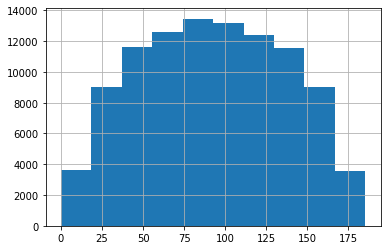

In [ ]:
print(data_0.info())
print(data_0.describe())
data_0['product'].hist();

In [ ]:
data_0.duplicated().sum() # проверим есть ли дубликаты в 1-ой таблице.

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.7340

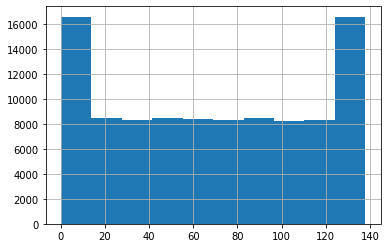

In [ ]:
print(data_1.info())
print(data_1.describe())
data_1['product'].hist();

In [ ]:
data_1.duplicated().sum() # проверим есть ли дубликаты в 2-ой таблице.

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.8448

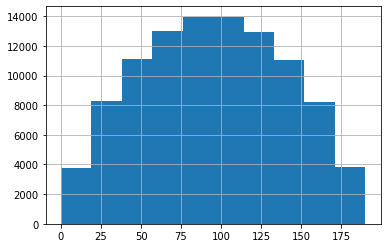

In [ ]:
print(data_2.info())
print(data_2.describe())
data_2['product'].hist();

In [ ]:
data_2.duplicated().sum() # проверим есть ли дубликаты в 3-ей таблице.

0

<b>Выводы:</b>

- Каждый из трех датасета содержат 5 столбцов и 10000 строк. 
- В данных нет явных выбросов, дубликатов и пропусков.
- Мы видим значительные отличия 2-го датасета от 1-го и 3-го, распределение объемов запасов в скважине не нормальное.

<b>Подготовка данных к обучению. </b>

- У нас нет категориальных признаков, поэтому применение кодировки не требуется. 
- Количественные признаки уже в одном формате, поэтому приводить данные к формату тоже не требуется.
- Поделим данные на тренировочную и валидационную выборки для каждого датафрейма по отдельности.

Для модели 1. 

In [ ]:
target = data_0['product']
features = data_0.drop(['id','product'], axis=1)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Для модели 2. 

In [ ]:
target = data_1['product']
features = data_1.drop(['id','product'], axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Для модели 3.

In [ ]:
target = data_2['product']
features = data_2.drop(['id','product'], axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features, target, test_size=0.25, random_state=12345)

### общие выводы раздела:
Мы имеем 3 датасета с общими признаками:

id — уникальный идентификатор скважины; <br/>
f0, f1, f2 — три признака точек;

И целевыми признаками:

product — объём запасов в скважине (тыс. баррелей).<br/>
Как говорилось выше, во 2-ом датасете распределение объемов запасов в скважине не нормальное.

<i>На этапе обработки:</i>

- Мы убрали из данных не информативные для нас столбцы с номером id,
- Поделили данные на тренировочную и валидационную выборки,
- Данные предобработаны и поделены на выборки. Теперь можно обучать модели и исследовать задачу.

## Обучение и проверка модели

Постольку наш целевой признак, который мы будем предсказывать количественный, то будем использовать модель регрессии. По условию задачи используем модель линейной регрессии. 

### Обучение первой модели.

In [ ]:
model = LinearRegression() # используем модель линейной регрессии
model.fit(features_train_0, target_train_0) # обучим модель на тренировочной выборке
predicted_valid_0 = model.predict(features_valid_0) #сделаем предсказание на валидационной выборке

r2_0 = model.score(features_valid_0, target_valid_0) # оценим качество модели
rmse_0 = mean_squared_error(target_valid_0, predicted_valid_0)**0.5

# расчитаем средний запас сырья и предсказанный средний запас сырья
target_mean_0 = target_valid_0.mean()
predicted_mean_0 = predicted_valid_0.mean()

print('R2 на валидационной выборке: ', r2_0) 
print('RMSE на валидационной выборке: ', rmse_0)
print('Средний запас сырья: ', target_mean_0)
print('Средний запас предсказанного сырья: ', predicted_mean_0)

R2 на валидационной выборке:  0.27994321524487786
RMSE на валидационной выборке:  37.5794217150813
Средний запас сырья:  92.07859674082927
Средний запас предсказанного сырья:  92.59256778438035


### Обучение второй модели.

In [ ]:
# Повторяем те же самые действия, что и с первой моделью.
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)

r2_1 = model.score(features_valid_1, target_valid_1)
rmse_1 = mean_squared_error(target_valid_1, predicted_valid_1)**0.5

target_mean_1 = target_valid_1.mean()
predicted_mean_1 = predicted_valid_1.mean()

print('R2 на валидационной выборке: ', r2_1) 
print('RMSE на валидационной выборке: ', rmse_1)
print('Средний запас сырья: ', target_mean_1)
print('Средний запас предсказанного сырья: ', predicted_mean_1)

R2 на валидационной выборке:  0.9996233978805127
RMSE на валидационной выборке:  0.893099286775617
Средний запас сырья:  68.72313602435997
Средний запас предсказанного сырья:  68.728546895446


### Обучение третьей модели.

In [ ]:
# Повторяем те же самые действия, что и с первой моделью.
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)

r2_2 = model.score(features_valid_2, target_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predicted_valid_2)**0.5

target_mean_2 = target_valid_2.mean()
predicted_mean_2 = predicted_valid_2.mean()

print('R2 на валидационной выборке: ', r2_2) 
print('RMSE на валидационной выборке: ', rmse_2)
print('Средний запас сырья: ', target_mean_2)
print('Средний запас предсказанного сырья: ', predicted_mean_2)

R2 на валидационной выборке:  0.20524758386040443
RMSE на валидационной выборке:  40.02970873393434
Средний запас сырья:  94.88423280885438
Средний запас предсказанного сырья:  94.96504596800489


### Выводы:

Выведем все наши результаты качества обученных моделей и предсказанный запас сырья в виде таблицы.

In [ ]:
print('Датасет |  rmse  |   r2   | Средний запас предсказанного сырья | Средний запас сырья')
print('------------------------------------------------------------------------------------')
print('data_0   {: <8.3f} {: <8.3f} {: 20.2f} {: 30.2f}'.format(r2_0, rmse_0, predicted_mean_0, target_mean_0))
print('data_1   {: <8.3f} {: <8.3f} {: 20.2f} {: 30.2f}'.format(r2_1, rmse_1, predicted_mean_1, target_mean_1))
print('data_2   {: <8.3f} {: <8.3f} {: 20.2f} {: 30.2f}'.format(r2_2, rmse_2, predicted_mean_2, target_mean_2))

Датасет |  rmse  |   r2   | Средний запас предсказанного сырья | Средний запас сырья
------------------------------------------------------------------------------------
data_0   0.280    37.579                  92.59                          92.08
data_1   1.000    0.893                   68.73                          68.72
data_2   0.205    40.030                  94.97                          94.88


Лучше всего модель обучилась по 2-му датасету и там самое низкое отклонение, но там меньше всего средняя по предсказанному запасу сырья и распределение не нормальное. Посмотрим ниже результаты расчета прибыли и рисков.

<div class="alert alert-block alert-success">
<b>Успех:</b> Шаг проделан хорошо, все нужные метрики посчитаны корректно. 
</div>
<div class="alert alert-block alert-info">
<b>Совет:</b> Можно было бы использовать функции/циклы и избежать дублирования кода. 
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> На практике используют цикл. Я почему-то даже не подумала об этом. Учту.
</div>

## Подготовка к расчёту прибыли

Создадим переменные для расчетов, которые указаны в условиях задачи.

In [ ]:
sample_borehole = 500 # объем исследуемых точек при разведке региона.
sample_development = 200 # объем выбранных лучших точек.
barrel_price = 450000 # стоимость барреля нефти
budget = 10000000000 # бюджет на разработку скважин в каждом регионе.

Расчитаем минимальное количество барелей нефти в каждой скважине для безубыточной разработки.

In [ ]:
min_volume = budget / (barrel_price * sample_development)
min_volume

111.11111111111111

Минимальный объем нефти - 111,1 тыс. барелей в каждой скважине нужно для безубыточной добычи.

## Расчёт прибыли и рисков 

Создадим функцию для расчета прибыли.

In [ ]:
def profit(target, predicted, count):
    profit = 0
    probs_sorted = predicted.sort_values(ascending=False).head(200)
    selected = target[probs_sorted.index][:count] 
    for top in selected:
        profit += (top - min_volume) * 450000
    return profit

Расчитаем прибыльность первого месторождения.

In [ ]:
features_valid_0['product_valid'] = predicted_valid_0

profit_0 = profit(target_valid_0, features_valid_0['product_valid'], 200)
print("Прибыльность 200 топовых скважин валидационной выборки", round(profit_0/1000000), "млн.")

Прибыльность 200 топовых скважин валидационной выборки 3321 млн.


Расчитаем прибыльность второго месторождения.

In [ ]:
features_valid_1['product_valid'] = predicted_valid_1

profit_1 = profit(target_valid_1, features_valid_1['product_valid'], 200)
print("Прибыльность 200 топовых скважин валидационной выборки", round(profit_1/1000000), "млн.")

Прибыльность 200 топовых скважин валидационной выборки 2415 млн.


Расчитаем прибыльность третьего месторождения.

In [ ]:
features_valid_2['product_valid'] = predicted_valid_2

profit_2 = profit(target_valid_2, features_valid_2['product_valid'], 200)
print("Прибыльность 200 топовых скважин валидационной выборки", round(profit_2/1000000), "млн.")

Прибыльность 200 топовых скважин валидационной выборки 2710 млн.


/tmp/ipykernel_100/219430070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid_2['product_valid'] = predicted_valid_2


Для расчета доверительного интервала и вероятности убытков создадим функцию бутстрепа.

In [ ]:
def boots (target, predicted):
    state = np.random.RandomState(12345)
    values = []
    counter=0
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        preds_subsample = predicted[target_subsample.index]
        
        values.append(profit(target_subsample, preds_subsample, 500))
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    
    print('Вероятность убытков', stats.percentileofscore(values, 0),'%')
    print('Средняя выручка', (values.mean())/1000000, "млн.")
    print('Верхняя граница доверительного интервала', higher)
    print('Нижняя граница доверительного интервала', lower)
    print()
    
# выведем расчеты для каждого месторождения.    
print('Для первого месторождения')
print()
print('RMSE', rmse_0)
print('R2', r2_0)
print('Предсказанный средний запас сырья', predicted_mean_0)
boots(target_valid_0, features_valid_0['product_valid'])
print()
print('Для второго месторождения')
print()
print('RMSE', rmse_1)
print('R2', r2_1)
print('Предсказанный средний запас сырья', predicted_mean_1)
boots(target_valid_1, features_valid_1['product_valid'])
print()
print('Для третьего месторождения')
print()
print('RMSE', rmse_2)
print('R2', r2_2)
print('Предсказанный средний запас сырья', predicted_mean_2)
boots(target_valid_2, features_valid_2['product_valid'])
    


Для первого месторождения

RMSE 37.5794217150813
R2 0.27994321524487786
Предсказанный средний запас сырья 92.59256778438035
Вероятность убытков 7.6 %
Средняя выручка 403.535244261165 млн.
Верхняя граница доверительного интервала 931574367.5508461
Нижняя граница доверительного интервала -118327362.12311177


Для второго месторождения

RMSE 0.893099286775617
R2 0.9996233978805127
Предсказанный средний запас сырья 68.728546895446
Вероятность убытков 1.7 %
Средняя выручка 465.04105822107704 млн.
Верхняя граница доверительного интервала 864388463.3254703
Нижняя граница доверительного интервала 32036742.850023583


Для третьего месторождения

RMSE 40.02970873393434
R2 0.20524758386040443
Предсказанный средний запас сырья 94.96504596800489
Вероятность убытков 7.9 %
Средняя выручка 414.20972284096746 млн.
Верхняя граница доверительного интервала 972339167.9202834
Нижняя граница доверительного интервала -148373898.68249217



## Выводы.

Проанализировав результаты можем сделать следующие выводы:

- Самая хорошая модель получилась по датасету 2-го региона, r2=0.89 и rmse = 0.99.
- У 2-го региона целевой признак имеет не нормальное распределение, что выделяется среди остальных регионов.
- Средняя выручка самая высокая во 2-м регионе.
- Вероятность убытков самая низкая во 2-м регионе, он единственный имеет положительную нижнюю границу доверительного интервала, что соответствует условиям задачи. </br>

Исходя из наших выводов очевидно - самый выгодный 2 регион, рекомендуем его к разработке.